# Relationships between AMOC & N. Atlantic SST in CESM2 PI Control

In [77]:
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import util
import copy
import xskillscore as xs
%matplotlib inline

from SMYLEutils import colormap_utils as mycolors

In [78]:
xs.__version__

'0.0.23'

In [79]:
import dask
from dask.distributed import wait
dask.__version__

'2021.09.0'

In [76]:
cluster.close()
client.close()

distributed.core - ERROR - Exception while handling op register-client
Traceback (most recent call last):
  File "/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/core.py", line 502, in handle_comm
    result = await result
  File "/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/scheduler.py", line 5249, in add_client
    self.remove_client(client=client)
  File "/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/scheduler.py", line 5276, in remove_client
    self.client_releases_keys(
  File "/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/scheduler.py", line 5014, in client_releases_keys
    self.transitions(recommendations)
  File "/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/scheduler.py", line 7119, in transitions
    self.send_all(client_msgs, worker_msgs)
  File "/glade/wor

In [80]:
def get_ClusterClient():
    #import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='03:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [81]:
cluster, client = get_ClusterClient()
cluster.scale(20) 

In [82]:
cluster

In [83]:
def time_set_midmonth(ds, time_name):
    year = ds[time_name].dt.year
    month = ds[time_name].dt.month
    year = xr.where(month==1,year-1,year)
    month = xr.where(month==1,12,month-1)
    nmonths = len(month)
    newtime = [cftime.DatetimeNoLeap(year[i], month[i], 15) for i in range(nmonths)]
    ds[time_name] = newtime
    return ds

In [9]:
#client.restart()

In [23]:
client.cancel(ds0)
client.cancel(ds1)
client.cancel(ds2)

In [84]:
%%time
pidir = '/glade/work/yeager/cesm_output/CESM2_picntrl/'
f0 = pidir+'b.e21.B1850.f09_g17.CMIP6-piControl.001.pop.h.000101-200012.MOC.nc'
ds0 = time_set_midmonth(xr.open_dataset(f0,chunks={'time':120}),'time').persist()
daskresult = wait(ds0)

CPU times: user 7.44 s, sys: 218 ms, total: 7.65 s
Wall time: 15.8 s


In [85]:
%%time
f1 = pidir+'b.e21.B1850.f09_g17.CMIP6-piControl.001.pop.h.000101-200012.MOCsig.nc'
ds1 = time_set_midmonth(xr.open_dataset(f1,chunks={'time':120}),'time').persist()
daskresult = wait(ds1)

CPU times: user 6.95 s, sys: 134 ms, total: 7.08 s
Wall time: 13.6 s


In [86]:
%%time
f2 = pidir+'b.e21.B1850.f09_g17.CMIP6-piControl.001.pop.h.000101-200012.N_HEAT.nc'
ds2 = time_set_midmonth(xr.open_dataset(f2,chunks={'time':600}),'time').persist()
daskresult = wait(ds2)

CPU times: user 5.87 s, sys: 58.1 ms, total: 5.92 s
Wall time: 6.27 s


In [87]:
ds0.nbytes/1.e9, ds1.nbytes/1.e9, ds2.nbytes/1.e9

(13.899947252, 19.794435556, 0.400427252)

In [88]:
%%time
# compute annual means
ds0_ann = ds0.groupby('time.year').mean('time').rename({'year':'time'})
ds1_ann = ds1.groupby('time.year').mean('time').rename({'year':'time'})
ds2_ann = ds2.groupby('time.year').mean('time').rename({'year':'time'})

CPU times: user 2min 3s, sys: 2.75 s, total: 2min 5s
Wall time: 2min 4s


In [89]:
%%time
ds0_ann = ds0_ann.sel(time=slice(201,2000))
ds1_ann = ds1_ann.sel(time=slice(201,2000))
ds2_ann = ds2_ann.sel(time=slice(201,2000))

CPU times: user 1.49 s, sys: 45.7 ms, total: 1.54 s
Wall time: 1.53 s


In [90]:
def preprocessor(ds0):
    ds0 = time_set_midmonth(ds0[['TEMP','TAREA','REGION_MASK']],'time')
    d0 = ds0.isel(z_t=0)
    return d0

In [91]:
%%time
# Get CESM2 Pi Control SST data
pidir = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850.f09_g17.CMIP6-piControl.001/ocn/proc/tseries/month_1/'
f3 = pidir+'b.e21.B1850.f09_g17.CMIP6-piControl.001.pop.h.TEMP.*.nc'
ds3_ann = xr.open_mfdataset(f3,preprocess=preprocessor,parallel=True,chunks={'time':240})
ds3_ann = ds3_ann.groupby('time.year').mean('time').rename({'year':'time'})
ds3_ann = ds3_ann.sel(time=slice(201,2000))

CPU times: user 17.1 s, sys: 448 ms, total: 17.6 s
Wall time: 21.4 s


## Load DataArrays

In [92]:
%%time
amoc_ann = ds0_ann.MOC.sum('moc_comp').isel(transport_reg=1).load()

CPU times: user 6.85 s, sys: 615 ms, total: 7.47 s
Wall time: 8.52 s


In [93]:
%%time
amocsig_ann = ds1_ann.MOCsig.sum('moc_comp').isel(transport_reg=1).load()

CPU times: user 6.17 s, sys: 696 ms, total: 6.87 s
Wall time: 6.83 s


In [94]:
%%time
mht_ann = ds2_ann.N_HEAT.isel(transport_comp=[1,3,4]).sum('transport_comp').isel(transport_reg=1).load()

CPU times: user 5.42 s, sys: 108 ms, total: 5.52 s
Wall time: 5.49 s


In [95]:
%%time
sst_ann = ds3_ann.TEMP.load()

CPU times: user 18.5 s, sys: 3.13 s, total: 21.6 s
Wall time: 2min 7s


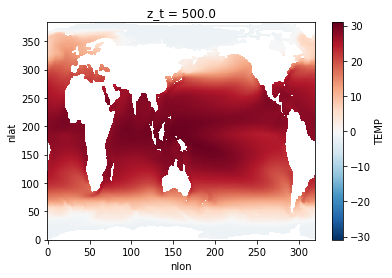

In [96]:
sst_ann.mean('time').plot();

## Compute LPF & detrended Data

In [97]:
%%time
# Mean & interannual anomalies
amoc_mean = amoc_ann.mean('time')
amocsig_mean = amocsig_ann.mean('time')
mht_mean = mht_ann.mean('time')
sst_mean = sst_ann.mean('time')
amoc_annanom = amoc_ann - amoc_mean
amocsig_annanom = amocsig_ann - amocsig_mean
mht_annanom = mht_ann - mht_mean
sst_annanom = sst_ann - sst_mean

CPU times: user 1.66 s, sys: 1.69 s, total: 3.35 s
Wall time: 2.99 s


In [98]:
def detrend_linear(dat, dim):
    """ linear detrend dat along the axis dim """
    params = dat.polyfit(dim=dim, deg=1)
    fit = xr.polyval(dat[dim], params.polyfit_coefficients)
    dat = dat-fit
    return dat

In [99]:
%%time
amoc_annanom_dt = detrend_linear(amoc_annanom,'time')
amocsig_annanom_dt = detrend_linear(amocsig_annanom,'time')
mht_annanom_dt = detrend_linear(mht_annanom,'time')
sst_annanom_dt = detrend_linear(sst_annanom,'time')

CPU times: user 14.4 s, sys: 10.6 s, total: 25 s
Wall time: 22.5 s


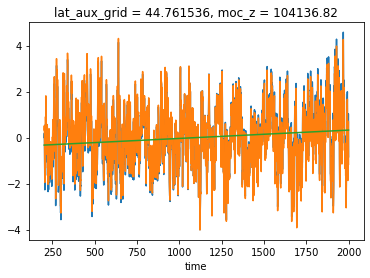

In [100]:
amoc_annanom.sel(lat_aux_grid=45,method='nearest').sel(moc_z=1000.*100.,method='nearest').plot();
amoc_annanom_dt.sel(lat_aux_grid=45,method='nearest').sel(moc_z=1000.*100.,method='nearest').plot();
(amoc_annanom-amoc_annanom_dt).sel(lat_aux_grid=45,method='nearest').sel(moc_z=1000.*100.,method='nearest').plot();

## Low-Pass Filtering

In [101]:
def lpf_anndata(dat, period=10):
    fs=1/(365*24*3600)        # 1 year in Hz (sampling frequency)
    nyquist = fs / 2          # 0.5 times the sampling frequency
    cutoff = fs/period            # cutoff frequency
    cutoff = cutoff/nyquist   # as fraction of nyquist  
    print('cutoff= ',(1/(cutoff*nyquist))/(365*24*3600),' years') 
    filtsos = signal.butter(4, cutoff, 'lowpass', output='sos') #low pass filter
    filtb, filta = signal.butter(4, cutoff, 'lowpass')
    dat_out = xr.apply_ufunc(signal.sosfiltfilt, filtsos,dat.fillna(0),kwargs={'padtype':'even','axis':0}).where(dat.notnull())
    return dat_out

In [102]:
%%time
# Low-Pass-Filtered & Detrended Anomalies:
amoc_annanom_dtlpf = lpf_anndata(amoc_annanom_dt,period=20)
amocsig_annanom_dtlpf = lpf_anndata(amocsig_annanom_dt,period=20)
mht_annanom_dtlpf = lpf_anndata(mht_annanom_dt,period=20)
sst_annanom_dtlpf = lpf_anndata(sst_annanom_dt,period=20)

cutoff=  20.0  years
cutoff=  20.0  years
cutoff=  20.0  years
cutoff=  20.0  years
CPU times: user 14.7 s, sys: 7.05 s, total: 21.7 s
Wall time: 19.6 s


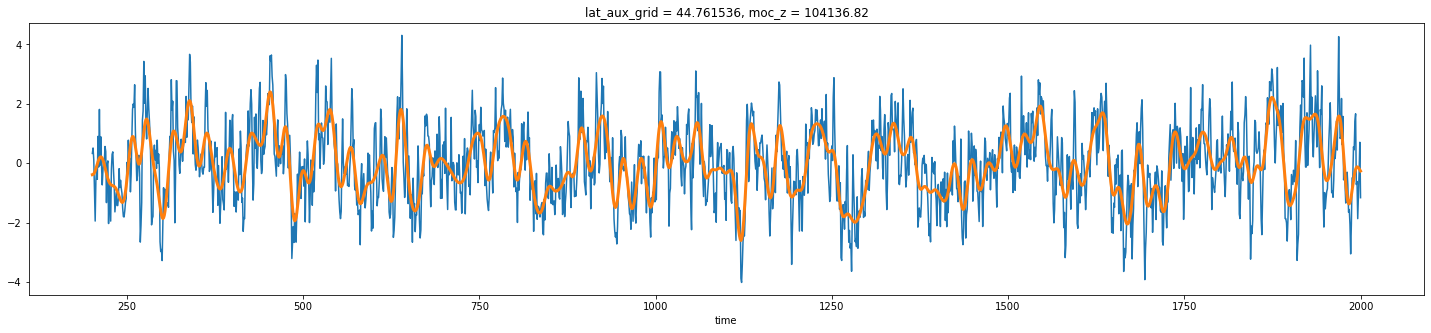

In [103]:
amoc_annanom_dt.sel(lat_aux_grid=45,method='nearest').sel(moc_z=1000.*100.,method='nearest').plot(aspect=5, size=5);
amoc_annanom_dtlpf.sel(lat_aux_grid=45,method='nearest').sel(moc_z=1000.*100.,method='nearest').plot(lw=3);

## Lag Regressions
- Still need to figure out how to use dask efficiently for this step

In [104]:
def lag_regress(x, y, lagx=0, lagy=0):
    x,y = xr.align(x,y)
    if lagx!=0:
        if lagx>0: x = x.shift(time = -lagx).isel(time=slice(0,-lagx))
        if lagx<0: x = x.shift(time = -lagx).isel(time=slice(-lagx,None))
    if lagy!=0:
        if lagy>0: y = y.shift(time = -lagy).isel(time=slice(0,-lagy))
        if lagy<0: y = y.shift(time = -lagy).isel(time=slice(-lagy,None))       
    x,y = xr.align(x,y)
    corr = xs.pearson_r(x,y,dim='time',skipna=True)
    slope = xs.linslope(x,y,dim='time',skipna=True)
    neff = xs.effective_sample_size(x,y,dim='time',skipna=True)
    pval = xs.pearson_r_eff_p_value(x,y,dim='time')
    stats = xr.DataArray(['corr','slope','pval','neff'],dims="stat",name="stat")
    xrout = xr.concat([corr,slope,pval,neff],dim=stats)
    return xrout

def concat_regress(x, y, lagyrange):
    """ y is a field being regressed onto x, with y lagging by lagyrange 
    """
    results = []
    lag = xr.DataArray([i for i in lagyrange],dims='lag',name='lag')
    for i in lagyrange:
        result = lag_regress(x,y,lagy=i)
        results.append(result)
    return xr.concat(results,dim=lag)

In [105]:
lagrange = range(-14,15,1)
lag = xr.DataArray([i for i in lagrange],dims='lag',name='lag')
lag

<xarray.DataArray 'lag' (lag: 29)>
array([-14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,
        -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14])
Dimensions without coordinates: lag

## SPNA, STNA, & AMV SST indices for regression

In [106]:
def POP_regional_areawgt(ds,lon_lim,lat_lim):
    tarea = ds.TAREA
    tlat = ds.TLAT
    tlon = xr.where(ds.TLONG>180.,ds.TLONG-360.,ds.TLONG)
    region = (tlat>=lat_lim[0]) & (tlat<=lat_lim[1]) & (tlon>=lon_lim[0]) & (tlon<=lon_lim[1])
    return xr.where(region,tarea.fillna(0),0)

In [107]:
POPg16_spna_area = POP_regional_areawgt(ds3_ann,[-45.,-15.],[45.,60.])
POPg16_stna_area = POP_regional_areawgt(ds3_ann,[-60.,-20.],[5.,25.])
POPg16_amv_area = POP_regional_areawgt(ds3_ann,[-75.,-7.],[0.,60.])

In [108]:
%%time
sst_spna = sst_annanom_dtlpf.weighted(POPg16_spna_area).mean(("nlon", "nlat")).load()

CPU times: user 28.6 s, sys: 4.87 s, total: 33.5 s
Wall time: 32.8 s


In [109]:
%%time
sst_stna = sst_annanom_dtlpf.weighted(POPg16_stna_area).mean(("nlon", "nlat")).load()

CPU times: user 29.7 s, sys: 4.87 s, total: 34.6 s
Wall time: 33.8 s


In [110]:
%%time
sst_amv = sst_annanom_dtlpf.weighted(POPg16_amv_area).mean(("nlon", "nlat")).load()

CPU times: user 28.2 s, sys: 5.29 s, total: 33.5 s
Wall time: 32 s


In [111]:
%%time
xdat = sst_spna
ydat = sst_stna
# Note xdat leads/lags for positive/negative lags
stnasst_reg_spnasst = concat_regress(xdat,ydat,lagrange).compute()

CPU times: user 681 ms, sys: 409 ms, total: 1.09 s
Wall time: 1.07 s


In [112]:
%%time
xdat = sst_amv
ydat = sst_stna
# Note xdat leads/lags for positive/negative lags
stnasst_reg_amv = concat_regress(xdat,ydat,lagrange).compute()

CPU times: user 365 ms, sys: 19.2 ms, total: 384 ms
Wall time: 377 ms


In [113]:
%%time
xdat = sst_amv
ydat = sst_spna
# Note xdat leads/lags for positive/negative lags
spnasst_reg_amv = concat_regress(xdat,ydat,lagrange).compute()

CPU times: user 326 ms, sys: 5.11 ms, total: 331 ms
Wall time: 325 ms


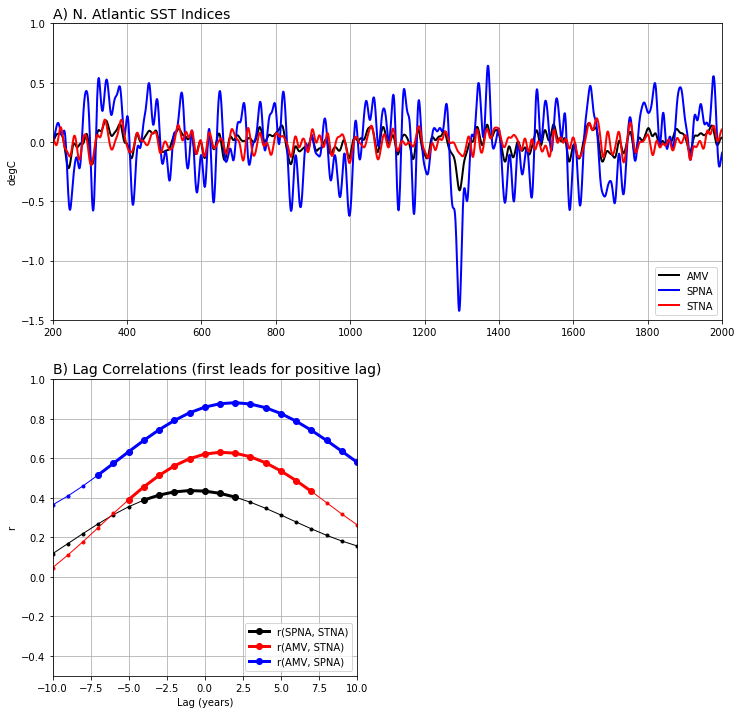

In [114]:
fig = plt.figure(figsize=(12, 12))
spec = fig.add_gridspec(ncols=2, nrows=2, figure=fig)
ax1 = fig.add_subplot(spec[0, 0:])
ax2 = fig.add_subplot(spec[1, 0])
fsize=14

sig = 1
ylim = [-1.5,1.]
xlim = [200,2000]
legloc = 'upper left'
siglvl = 0.1

ax1.set_ylabel('degC')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)
ax1.set_title(r'A) N. Atlantic SST Indices', fontdict={'size':fsize},loc='left')
ax1.plot(sst_amv.time, sst_amv,linewidth=2,color='k',label='AMV')
ax1.plot(sst_spna.time, sst_spna,linewidth=2,color='b',label='SPNA')
ax1.plot(sst_stna.time, sst_stna,linewidth=2,color='r',label='STNA')
ax1.grid()
ax1.legend(loc='lower right')

ax2.set_xlabel('Lag (years)')
ax2.set_ylabel('r')
ax2.set_ylim([-0.5,1])
ax2.set_xlim([-10,10])
ax2.set_title(r'B) Lag Correlations (first leads for positive lag)', fontdict={'size':fsize},loc='left')
plt2a = ax2.plot(stnasst_reg_spnasst.lag, stnasst_reg_spnasst.sel(stat='corr'),color='k',marker='.',linewidth=1)
work2b = stnasst_reg_spnasst.where(stnasst_reg_spnasst.sel(stat='pval') < siglvl)
plt2b = ax2.plot(work2b.lag,work2b.sel(stat='corr'), color='k', marker='o',linewidth=3,label='r(SPNA, STNA)')
plt2c = ax2.plot(stnasst_reg_amv.lag, stnasst_reg_amv.sel(stat='corr'),color='r',marker='.',linewidth=1)
work2d = stnasst_reg_amv.where(stnasst_reg_amv.sel(stat='pval') < siglvl)
plt2d = ax2.plot(work2d.lag,work2d.sel(stat='corr'), color='r', marker='o',linewidth=3,label='r(AMV, STNA)')
plt2e = ax2.plot(spnasst_reg_amv.lag, spnasst_reg_amv.sel(stat='corr'),color='b',marker='.',linewidth=1)
work2f = spnasst_reg_amv.where(spnasst_reg_amv.sel(stat='pval') < siglvl)
plt2f = ax2.plot(work2f.lag,work2f.sel(stat='corr'), color='b', marker='o',linewidth=3,label='r(AMV, SPNA)')

ax2.grid()
ax2.legend(loc='lower right')

##### AMV leads STNA by \~1 year and SPNA by \~2 year. AMV is more strongly related to SPNA (r\~0.9) than STNA (r\~0.6). STNA leads SPNA by \~1 year.  

In [115]:
%%time
xdat = sst_spna.chunk()
ydat = amoc_annanom_dtlpf.chunk({'moc_z':20})
AMOC_reg_spnasst = concat_regress(xdat,ydat,lagrange).persist()
daskresult = wait(AMOC_reg_spnasst)

CPU times: user 8.36 s, sys: 956 ms, total: 9.32 s
Wall time: 35.7 s


In [116]:
%%time
xdat = sst_spna.chunk()
ydat = amocsig_annanom_dtlpf.chunk({'moc_s':20})
AMOCsig_reg_spnasst = concat_regress(xdat,ydat,lagrange).persist()
daskresult = wait(AMOCsig_reg_spnasst)

CPU times: user 11.5 s, sys: 1.3 s, total: 12.8 s
Wall time: 42.7 s


In [117]:
%%time
xdat = sst_stna.chunk()
ydat = amoc_annanom_dtlpf.chunk({'moc_z':20})
AMOC_reg_stnasst = concat_regress(xdat,ydat,lagrange).persist()
daskresult = wait(AMOC_reg_stnasst)

CPU times: user 7.28 s, sys: 922 ms, total: 8.2 s
Wall time: 30.3 s


In [118]:
%%time
xdat = sst_stna.chunk()
ydat = amocsig_annanom_dtlpf.chunk({'moc_s':20})
AMOCsig_reg_stnasst = concat_regress(xdat,ydat,lagrange).persist()
daskresult = wait(AMOCsig_reg_stnasst)

CPU times: user 10.3 s, sys: 1.19 s, total: 11.5 s
Wall time: 41.5 s


In [119]:
%%time
xdat = sst_amv.chunk()
ydat = amoc_annanom_dtlpf.chunk({'moc_z':20})
AMOC_reg_amv = concat_regress(xdat,ydat,lagrange).persist()
daskresult = wait(AMOC_reg_amv)

CPU times: user 9.18 s, sys: 1.07 s, total: 10.2 s
Wall time: 30.3 s


In [120]:
%%time
xdat = sst_amv.chunk()
ydat = amocsig_annanom_dtlpf.chunk({'moc_s':20})
AMOCsig_reg_amv = concat_regress(xdat,ydat,lagrange).persist()
daskresult = wait(AMOCsig_reg_amv)

CPU times: user 10.2 s, sys: 1.4 s, total: 11.6 s
Wall time: 41.5 s


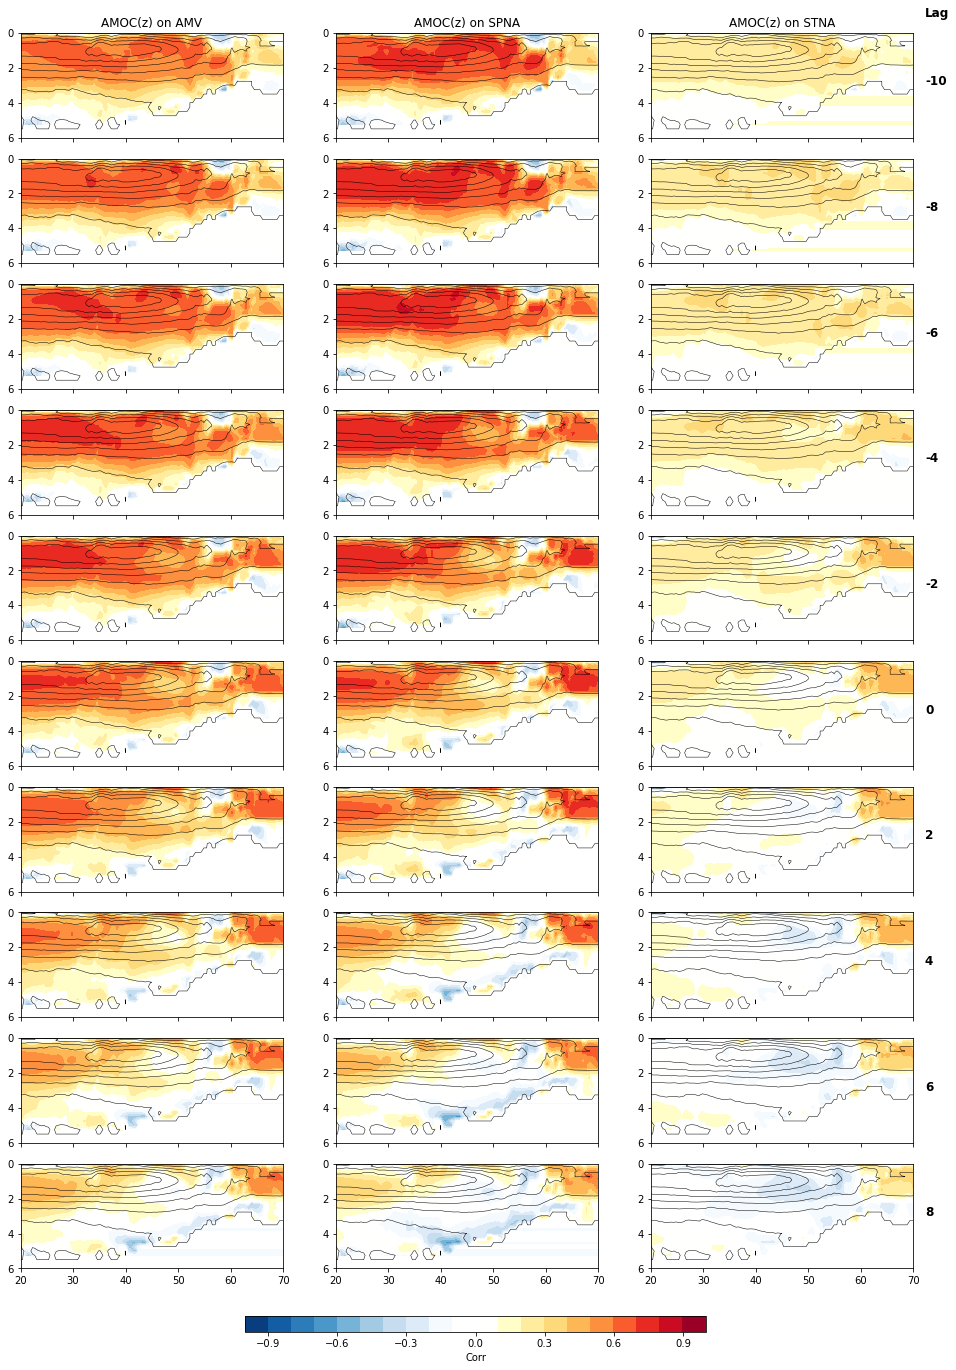

In [121]:
siglvl = 0.1
fig = plt.figure(figsize=(16, 22))

mnlevs = np.arange(0,17,1)*4. - 4.
# set up contour levels and color map
cmin=-1; cmax=1; ci=0.1
nlevs = (cmax-cmin)/ci + 1
rlevs = np.arange(cmin, cmax+ci, ci)
colmap = mycolors.blue2red_cmap(nlevs)
#colmap = copy.copy(plt.cm.RdYlBu_r)
faceclr = 'lightsteelblue'
lags = [-10,-8,-6,-4,-2,0,2,4,6,8]
yticks = [30,40,50,60,70]
yticklabs = ('30','40','50','60','70')
xticks = [-60,-50,-40,-30,-20,-10]
xticklabs = [str(e) for e in xticks]
fontsize=12

nrow = np.shape(lags)[0]
ncol = 3

moc_z = amoc_mean.moc_z/100./1000.
for i in range(nrow):
    thislag = lags[i]
    work = AMOC_reg_amv.sel(lag=thislag).sel(stat='corr')
    ax = fig.add_subplot(nrow,ncol,i*ncol+1)
    cntr = ax.contour(amoc_mean.lat_aux_grid, moc_z, amoc_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntrf1 = ax.contourf(work.lat_aux_grid, moc_z, work,levels=rlevs, cmap=colmap)
    if i<(nrow-1): ax.set_xticklabels([])
    if i==0: ax.set_title(r'AMOC(z) on AMV', fontdict={'size':fontsize}, loc='center')
    ax.set_ylim(6., 0.)
    ax.set_xlim(20, 70)

for i in range(nrow):
    thislag = lags[i]
    work = AMOC_reg_spnasst.sel(lag=thislag).sel(stat='corr')
    ax = fig.add_subplot(nrow,ncol,i*ncol+2)
    cntr = ax.contour(amoc_mean.lat_aux_grid, moc_z, amoc_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntrf1 = ax.contourf(work.lat_aux_grid, moc_z, work,levels=rlevs, cmap=colmap)
    if i<(nrow-1): ax.set_xticklabels([])
    if i==0: ax.set_title(r'AMOC(z) on SPNA', fontdict={'size':fontsize}, loc='center')
    ax.set_ylim(6., 0.)
    ax.set_xlim(20, 70)

axlist = []
for i in range(nrow):
    thislag = lags[i]
    work = AMOC_reg_stnasst.sel(lag=thislag).sel(stat='corr')
    ax = fig.add_subplot(nrow,ncol,i*ncol+3)
    cntr = ax.contour(amoc_mean.lat_aux_grid, moc_z, amoc_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntrf1 = ax.contourf(work.lat_aux_grid, moc_z, work,levels=rlevs, cmap=colmap)
    if i<(nrow-1): ax.set_xticklabels([])
    if i==0: ax.set_title(r'AMOC(z) on STNA', fontdict={'size':fontsize}, loc='center')
    ax.set_ylim(6., 0.)
    ax.set_xlim(20, 70)
    axlist.append(ax)

fig.subplots_adjust(bottom=0.1,right=0.9)
cbar_ax1 = fig.add_axes([0.32, 0.06, 0.4, 0.01])
fig.colorbar(cntrf1, cax=cbar_ax1, label='Corr', orientation='horizontal')

fig.text(0.91, 0.89, 'Lag', fontsize=fontsize, fontweight='bold')
for i in range(nrow):
    thisax = axlist[i]
    thislag = lags[i]
    pos1 = thisax.get_position()
    fig.text(0.91, pos1.y0+pos1.height/2, str(thislag), fontsize=fontsize, fontweight='bold')

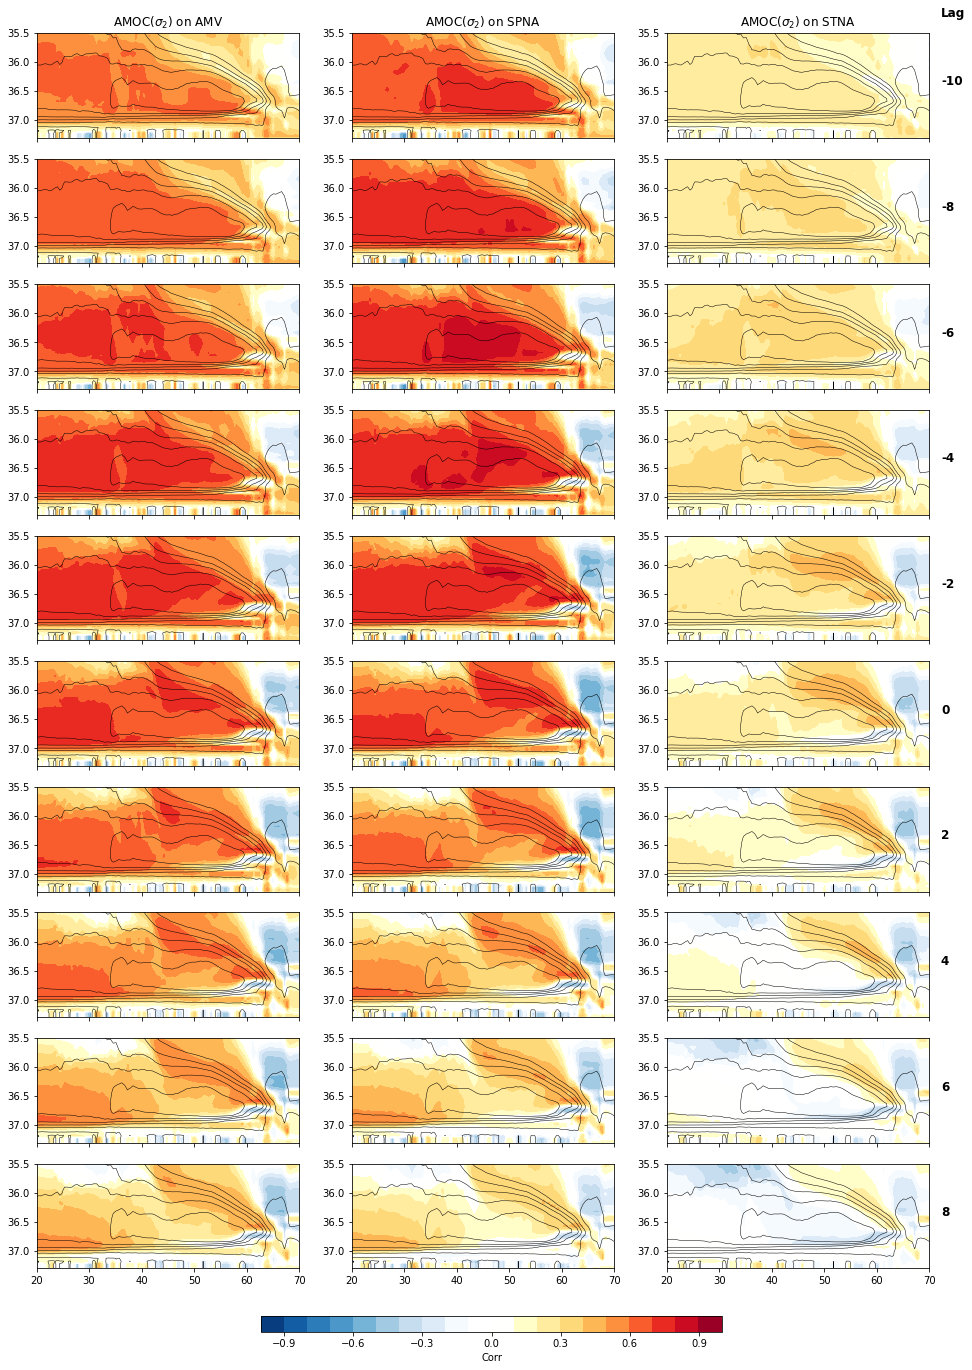

In [122]:
siglvl = 0.1
fig = plt.figure(figsize=(16, 22))

mnlevs = np.arange(0,17,1)*4. - 4.
# set up contour levels and color map
cmin=-1; cmax=1; ci=0.1
nlevs = (cmax-cmin)/ci + 1
rlevs = np.arange(cmin, cmax+ci, ci)
colmap = mycolors.blue2red_cmap(nlevs)
#colmap = copy.copy(plt.cm.RdYlBu_r)
faceclr = 'lightsteelblue'
lags = [-10,-8,-6,-4,-2,0,2,4,6,8]
yticks = [30,40,50,60,70]
yticklabs = ('30','40','50','60','70')
xticks = [-60,-50,-40,-30,-20,-10]
xticklabs = [str(e) for e in xticks]
fontsize=12

nrow = np.shape(lags)[0]
ncol = 3

moc_s = amocsig_mean.moc_s
for i in range(nrow):
    thislag = lags[i]
    work = AMOCsig_reg_amv.sel(lag=thislag).sel(stat='corr')
    ax = fig.add_subplot(nrow,ncol,i*ncol+1)
    cntr = ax.contour(amocsig_mean.lat_aux_grid, moc_s, amocsig_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntrf1 = ax.contourf(work.lat_aux_grid, moc_s, work,levels=rlevs, cmap=colmap)
    if i<(nrow-1): ax.set_xticklabels([])
    if i==0: ax.set_title(r'AMOC($\sigma_2$) on AMV', fontdict={'size':fontsize}, loc='center')
    ax.set_ylim(37.3, 35.5)
    ax.set_xlim(20, 70)

for i in range(nrow):
    thislag = lags[i]
    work = AMOCsig_reg_spnasst.sel(lag=thislag).sel(stat='corr')
    ax = fig.add_subplot(nrow,ncol,i*ncol+2)
    cntr = ax.contour(amocsig_mean.lat_aux_grid, moc_s, amocsig_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntrf1 = ax.contourf(work.lat_aux_grid, moc_s, work,levels=rlevs, cmap=colmap)
    if i<(nrow-1): ax.set_xticklabels([])
    if i==0: ax.set_title(r'AMOC($\sigma_2$) on SPNA', fontdict={'size':fontsize}, loc='center')
    ax.set_ylim(37.3, 35.5)
    ax.set_xlim(20, 70)

axlist = []
for i in range(nrow):
    thislag = lags[i]
    work = AMOCsig_reg_stnasst.sel(lag=thislag).sel(stat='corr')
    ax = fig.add_subplot(nrow,ncol,i*ncol+3)
    cntr = ax.contour(amocsig_mean.lat_aux_grid, moc_s, amocsig_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntrf1 = ax.contourf(work.lat_aux_grid, moc_s, work,levels=rlevs, cmap=colmap)
    if i<(nrow-1): ax.set_xticklabels([])
    if i==0: ax.set_title(r'AMOC($\sigma_2$) on STNA', fontdict={'size':fontsize}, loc='center')
    ax.set_ylim(37.3, 35.5)
    ax.set_xlim(20, 70)
    axlist.append(ax)

fig.subplots_adjust(bottom=0.1,right=0.9)
cbar_ax1 = fig.add_axes([0.32, 0.06, 0.4, 0.01])
fig.colorbar(cntrf1, cax=cbar_ax1, label='Corr', orientation='horizontal')

fig.text(0.91, 0.89, 'Lag', fontsize=fontsize, fontweight='bold')
for i in range(nrow):
    thisax = axlist[i]
    thislag = lags[i]
    pos1 = thisax.get_position()
    fig.text(0.91, pos1.y0+pos1.height/2, str(thislag), fontsize=fontsize, fontweight='bold')

In [123]:
amoc_ind = amoc_annanom_dtlpf.sel(moc_z=slice(500*100.,1500*100.)).sel(lat_aux_grid=slice(30,40)).mean(['moc_z','lat_aux_grid'])
amocsig_ind = amocsig_annanom_dtlpf.sel(moc_s=slice(35.75,36.25)).sel(lat_aux_grid=slice(45,55)).mean(['moc_s','lat_aux_grid'])

In [124]:
lagrange = range(-18,19,1)
lag = xr.DataArray([i for i in lagrange],dims='lag',name='lag')
lag

<xarray.DataArray 'lag' (lag: 37)>
array([-18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,
        -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,
         8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18])
Dimensions without coordinates: lag

In [125]:
%%time
xdat = amoc_ind
ydat = sst_spna
# Note xdat leads/lags for positive/negative lags
spna_reg_amoc = concat_regress(xdat,ydat,lagrange)
xdat = amocsig_ind
spna_reg_amocsig = concat_regress(xdat,ydat,lagrange)

CPU times: user 753 ms, sys: 19.2 ms, total: 772 ms
Wall time: 760 ms


In [126]:
%%time
xdat = amoc_ind
ydat = sst_stna
# Note xdat leads/lags for positive/negative lags
stna_reg_amoc = concat_regress(xdat,ydat,lagrange)
xdat = amocsig_ind
stna_reg_amocsig = concat_regress(xdat,ydat,lagrange)

CPU times: user 758 ms, sys: 8.98 ms, total: 767 ms
Wall time: 756 ms


In [127]:
%%time
xdat = amoc_ind
ydat = sst_amv
# Note xdat leads/lags for positive/negative lags
amv_reg_amoc = concat_regress(xdat,ydat,lagrange)
xdat = amocsig_ind
amv_reg_amocsig = concat_regress(xdat,ydat,lagrange)

CPU times: user 757 ms, sys: 12.3 ms, total: 769 ms
Wall time: 758 ms


In [130]:
%%time
ydat = amoc_ind
xdat = amocsig_ind
amoc_reg_amocsig = concat_regress(xdat,ydat,lagrange)

CPU times: user 397 ms, sys: 7 ms, total: 404 ms
Wall time: 399 ms


In [75]:
#amocsig_ind.to_dataset(name='AMOCindex').to_netcdf('/glade/scratch/yeager/CESM2_AMOCindex_0201-2000.nc')

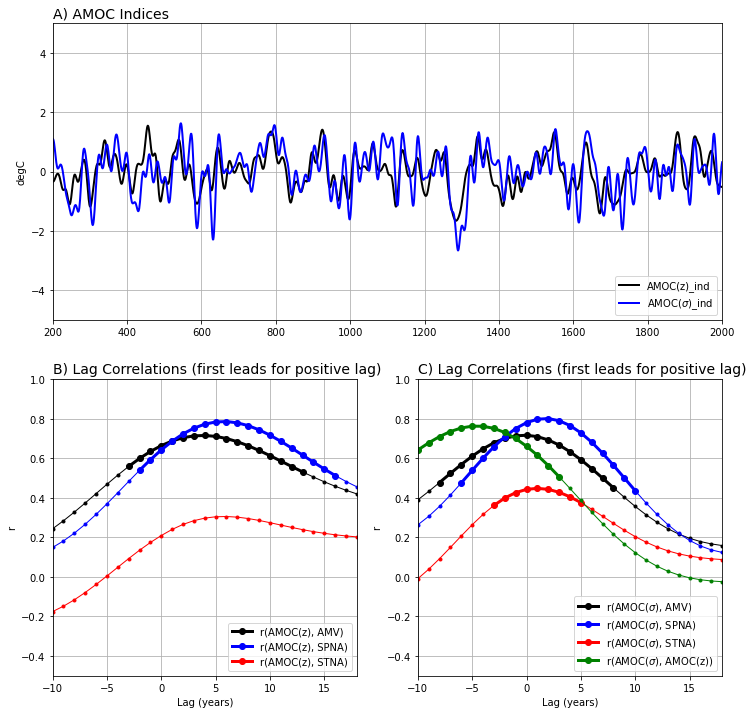

In [131]:
fig = plt.figure(figsize=(12, 12))
spec = fig.add_gridspec(ncols=2, nrows=2, figure=fig)
ax1 = fig.add_subplot(spec[0, 0:])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[1, 1])
fsize=14

sig = 1
ylim = [-5,5.]
xlim = [200,2000]
legloc = 'upper left'
siglvl = 0.1

ax1.set_ylabel('degC')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)
ax1.set_title(r'A) AMOC Indices', fontdict={'size':fsize},loc='left')
ax1.plot(amoc_ind.time, amoc_ind,linewidth=2,color='k',label='AMOC(z)_ind')
ax1.plot(amocsig_ind.time, amocsig_ind,linewidth=2,color='b',label=r'AMOC($\sigma$)_ind')
ax1.grid()
ax1.legend(loc='lower right')

ax2.set_xlabel('Lag (years)')
ax2.set_ylabel('r')
ax2.set_ylim([-0.5,1])
ax2.set_xlim([-10,18])
ax2.set_title(r'B) Lag Correlations (first leads for positive lag)', fontdict={'size':fsize},loc='left')
plt2a = ax2.plot(amv_reg_amoc.lag, amv_reg_amoc.sel(stat='corr'),color='k',marker='.',linewidth=1)
work2b = amv_reg_amoc.where(amv_reg_amoc.sel(stat='pval') < siglvl)
plt2b = ax2.plot(work2b.lag,work2b.sel(stat='corr'), color='k', marker='o',linewidth=3,label='r(AMOC(z), AMV)')
plt2c = ax2.plot(spna_reg_amoc.lag, spna_reg_amoc.sel(stat='corr'),color='b',marker='.',linewidth=1)
work2d = spna_reg_amoc.where(spna_reg_amoc.sel(stat='pval') < siglvl)
plt2d = ax2.plot(work2d.lag,work2d.sel(stat='corr'), color='b', marker='o',linewidth=3,label='r(AMOC(z), SPNA)')
plt2e = ax2.plot(stna_reg_amoc.lag, stna_reg_amoc.sel(stat='corr'),color='r',marker='.',linewidth=1)
work2f = stna_reg_amoc.where(stna_reg_amoc.sel(stat='pval') < siglvl)
plt2f = ax2.plot(work2f.lag,work2f.sel(stat='corr'), color='r', marker='o',linewidth=3,label='r(AMOC(z), STNA)')
ax2.grid()
ax2.legend(loc='lower right')

ax3.set_xlabel('Lag (years)')
ax3.set_ylabel('r')
ax3.set_ylim([-0.5,1])
ax3.set_xlim([-10,18])
ax3.set_title(r'C) Lag Correlations (first leads for positive lag)', fontdict={'size':fsize},loc='left')
plt3a = ax3.plot(amv_reg_amocsig.lag, amv_reg_amocsig.sel(stat='corr'),color='k',marker='.',linewidth=1)
work3b = amv_reg_amocsig.where(amv_reg_amocsig.sel(stat='pval') < siglvl)
plt3b = ax3.plot(work3b.lag,work3b.sel(stat='corr'), color='k', marker='o',linewidth=3,label=r'r(AMOC($\sigma$), AMV)')
plt3c = ax3.plot(spna_reg_amocsig.lag, spna_reg_amocsig.sel(stat='corr'),color='b',marker='.',linewidth=1)
work3d = spna_reg_amocsig.where(spna_reg_amocsig.sel(stat='pval') < siglvl)
plt3d = ax3.plot(work3d.lag,work3d.sel(stat='corr'), color='b', marker='o',linewidth=3,label=r'r(AMOC($\sigma$), SPNA)')
plt3e = ax3.plot(stna_reg_amocsig.lag, stna_reg_amocsig.sel(stat='corr'),color='r',marker='.',linewidth=1)
work3f = stna_reg_amocsig.where(stna_reg_amocsig.sel(stat='pval') < siglvl)
plt3f = ax3.plot(work3f.lag,work3f.sel(stat='corr'), color='r', marker='o',linewidth=3,label=r'r(AMOC($\sigma$), STNA)')
plt3g = ax3.plot(amoc_reg_amocsig.lag, amoc_reg_amocsig.sel(stat='corr'),color='g',marker='.',linewidth=1)
work3h = amoc_reg_amocsig.where(amoc_reg_amocsig.sel(stat='pval') < siglvl)
plt3h = ax3.plot(work3h.lag,work3h.sel(stat='corr'), color='g', marker='o',linewidth=3,label=r'r(AMOC($\sigma$), AMOC(z))')

ax3.grid()
ax3.legend(loc='lower right')

In [56]:
lagrange = range(-4,16,2)
lag = xr.DataArray([i for i in lagrange],dims='lag',name='lag')
lag

<xarray.DataArray 'lag' (lag: 10)>
array([-4, -2,  0,  2,  4,  6,  8, 10, 12, 14])
Dimensions without coordinates: lag

In [57]:
%%time
xdat = amoc_ind.chunk()
ydat = sst_annanom_dtlpf.chunk({'nlat':60})
sst_reg_amoc = concat_regress(xdat,ydat,lagrange).persist()
daskresult = wait(sst_reg_amoc)

CPU times: user 21.7 s, sys: 3.26 s, total: 24.9 s
Wall time: 1min 12s


In [58]:
%%time
xdat = amocsig_ind.chunk()
ydat = sst_annanom_dtlpf.chunk({'nlat':60})
sst_reg_amocsig = concat_regress(xdat,ydat,lagrange).persist()
daskresult = wait(sst_reg_amocsig)

CPU times: user 21.6 s, sys: 2.98 s, total: 24.6 s
Wall time: 1min 9s


In [59]:
%%time
xdat = sst_amv.chunk()
ydat = sst_annanom_dtlpf.chunk({'nlat':60})
sst_reg_amv = concat_regress(xdat,ydat,lagrange).persist()
daskresult = wait(sst_reg_amv)

CPU times: user 22.3 s, sys: 3.21 s, total: 25.5 s
Wall time: 1min 10s


In [60]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

/glade/scratch/yeager/tmp/ipykernel_190376/4166106860.py:67: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(bottom=0.1,right=0.9)


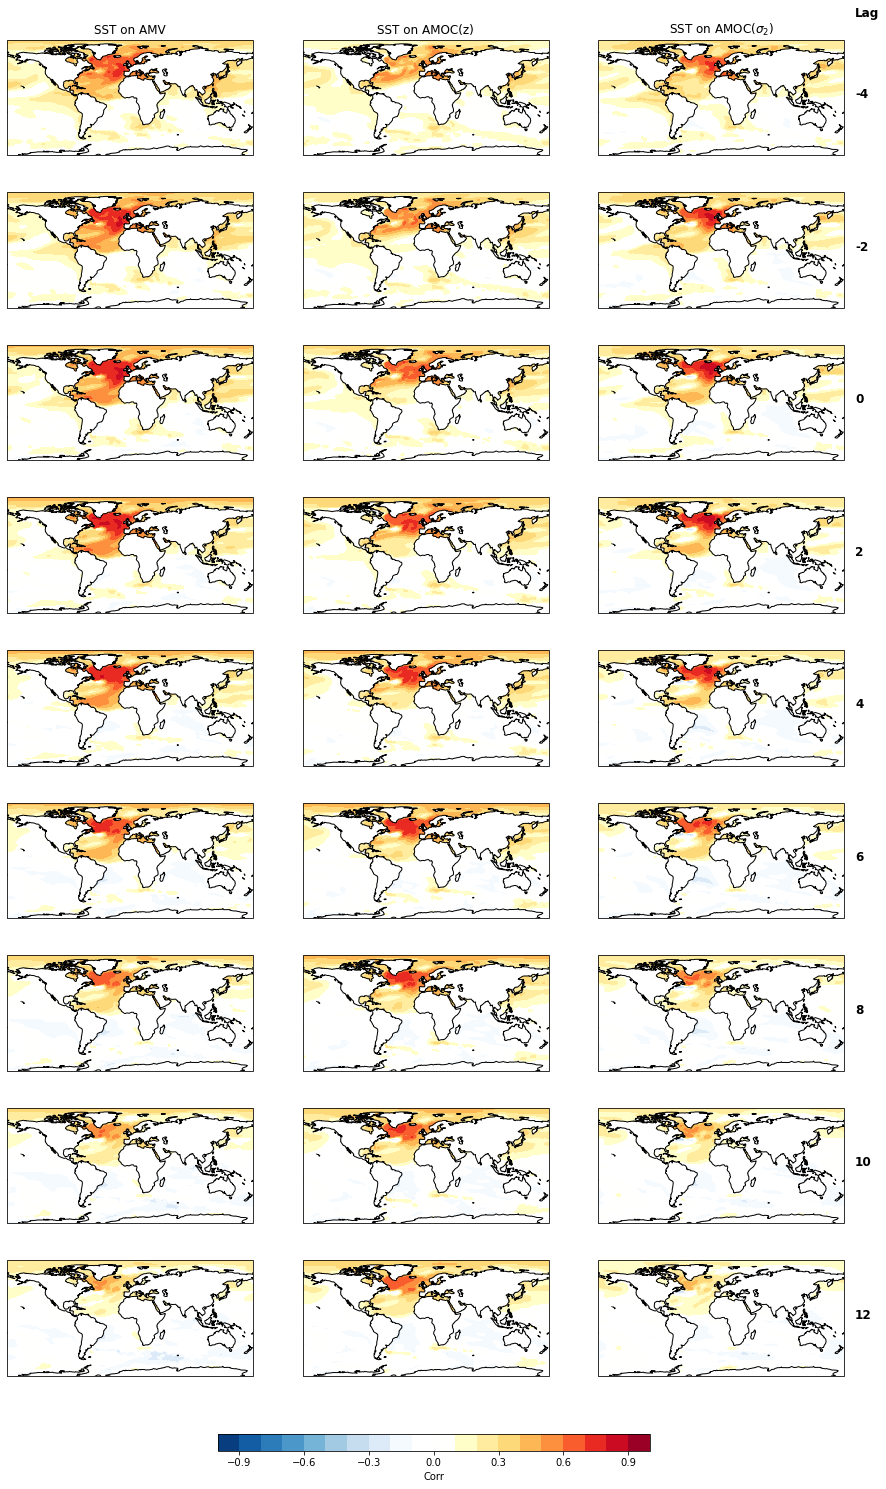

In [61]:
siglvl = 0.1
fig = plt.figure(figsize=(15, 24))

mnlevs = np.arange(0,17,1)*4. - 4.
# set up contour levels and color map
cmin=-1; cmax=1; ci=0.1
nlevs = (cmax-cmin)/ci + 1
rlevs = np.arange(cmin, cmax+ci, ci)
colmap = mycolors.blue2red_cmap(nlevs)
#colmap = copy.copy(plt.cm.RdYlBu_r)
faceclr = 'lightsteelblue'
lags = [-4,-2,-0,2,4,6,8,10,12]
extent = [-180, 180, -70, 70]
proj = ccrs.PlateCarree()
yticks = [30,40,50,60,70]
yticklabs = ('30','40','50','60','70')
xticks = [-60,-50,-40,-30,-20,-10]
xticklabs = [str(e) for e in xticks]
fontsize=12

tlon = sst_mean.TLONG
tlon = xr.where(tlon>180.,tlon-360.,tlon)
tlat = sst_mean.TLAT

nrow = np.shape(lags)[0]
ncol = 3

# SST on AMV plots:
for i in range(nrow):
    thislag = lags[i]
    work = sst_reg_amv.sel(lag=thislag).sel(stat='corr')
    lon, lat, dat = adjust_pop_grid(tlon, tlat, work)
    ax = fig.add_subplot(nrow,ncol,i*ncol+1,projection=proj)
    cntrf0 = ax.contourf(lon,lat, dat,levels=rlevs, cmap=colmap,transform=ccrs.PlateCarree())
    ax.coastlines()
    #if i<(nrow-1): ax.set_xticklabels([])
    if i==0: ax.set_title(r'SST on AMV', fontdict={'size':fontsize}, loc='center')
    #ax.set_extent(extent)

# SST on MOCz plots:
for i in range(nrow):
    thislag = lags[i]
    work = sst_reg_amoc.sel(lag=thislag).sel(stat='corr')
    lon, lat, dat = adjust_pop_grid(tlon, tlat, work)
    ax = fig.add_subplot(nrow,ncol,i*ncol+2,projection=proj)
    cntrf1 = ax.contourf(lon,lat, dat,levels=rlevs, cmap=colmap,transform=ccrs.PlateCarree())
    ax.coastlines()
    #if i<(nrow-1): ax.set_xticklabels([])
    if i==0: ax.set_title(r'SST on AMOC(z)', fontdict={'size':fontsize}, loc='center')
    #ax.set_extent(extent)


# SST on MOCsig plots:
axlist = []
for i in range(nrow):
    thislag = lags[i]
    work = sst_reg_amocsig.sel(lag=thislag).sel(stat='corr')
    lon, lat, dat = adjust_pop_grid(tlon, tlat, work)
    ax = fig.add_subplot(nrow,ncol,i*ncol+3,projection=proj)
    cntrf1 = ax.contourf(lon, lat, dat,levels=rlevs, cmap=colmap,transform=ccrs.PlateCarree())
    ax.coastlines()
    if i<(nrow-1): ax.set_xticklabels([])
    if i==0: ax.set_title(r'SST on AMOC($\sigma_2$)', fontdict={'size':fontsize}, loc='center')
    #ax.set_extent(extent)
    axlist.append(ax)

fig.subplots_adjust(bottom=0.1,right=0.9)
cbar_ax1 = fig.add_axes([0.32, 0.06, 0.4, 0.01])
fig.colorbar(cntrf1, cax=cbar_ax1, label='Corr', orientation='horizontal')

fig.text(0.91, 0.89, 'Lag', fontsize=fontsize, fontweight='bold')
for i in range(nrow):
    thisax = axlist[i]
    thislag = lags[i]
    pos1 = thisax.get_position()
    fig.text(0.91, pos1.y0+pos1.height/2, str(thislag), fontsize=fontsize, fontweight='bold')
#plt.tight_layout()

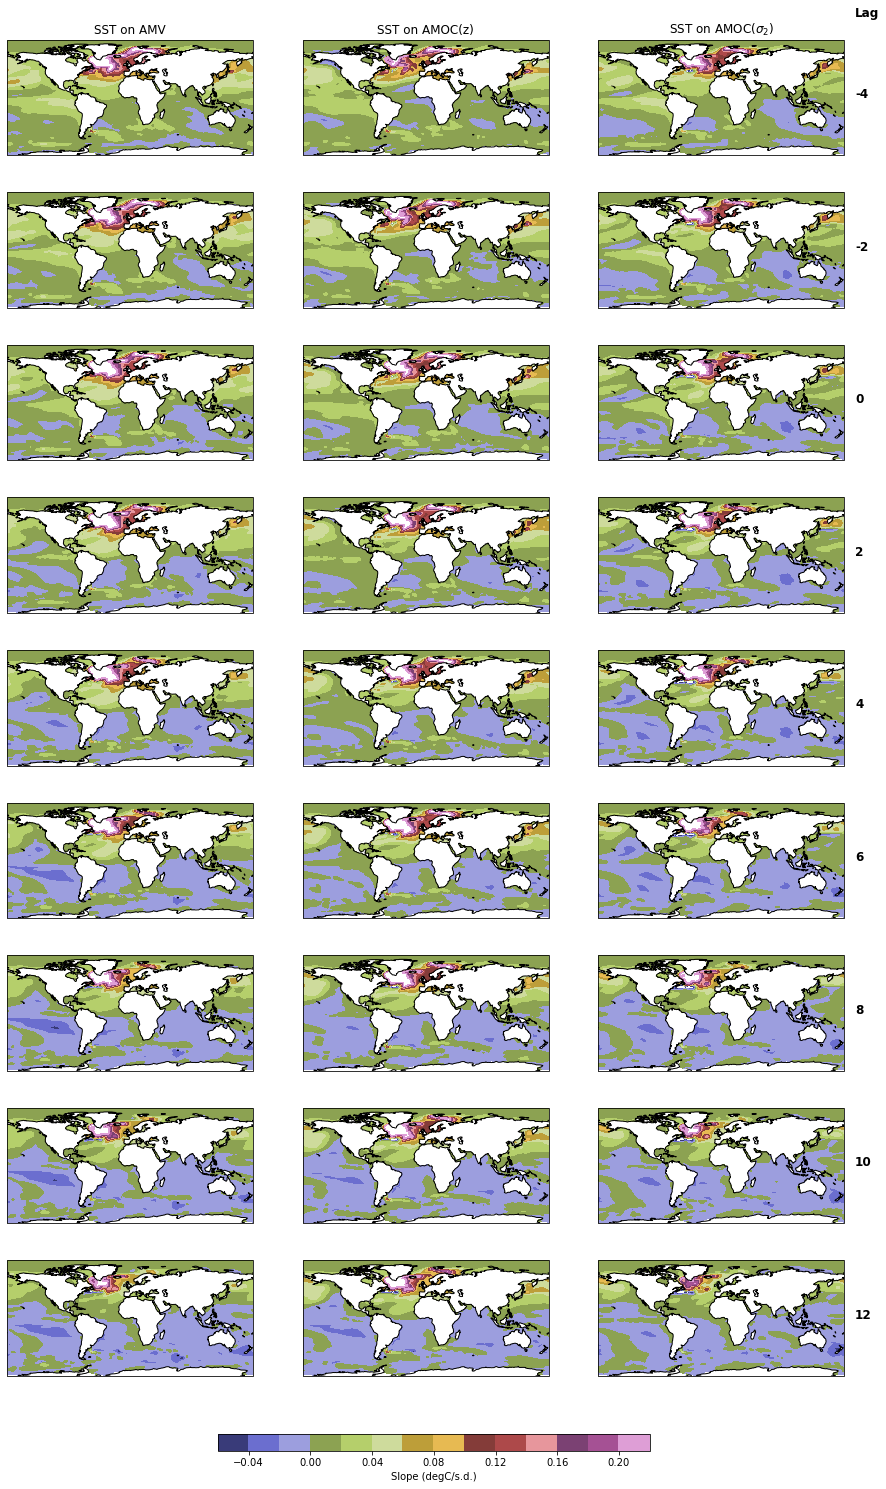

In [72]:
siglvl = 0.1
fig = plt.figure(figsize=(15, 24))

mnlevs = np.arange(0,17,1)*4. - 4.
# set up contour levels and color map
cmin=-0.06; cmax=0.2; ci=0.02
nlevs = (cmax-cmin)/ci + 1
rlevs = np.arange(cmin, cmax+ci, ci)
#colmap = mycolors.blue2red_cmap(nlevs)
#colmap = mycolors.precip_cmap(nlevs)
#colmap = copy.copy(plt.cm.terrain)
colmap = copy.copy(plt.cm.tab20b)
#colmap = copy.copy(plt.cm.RdYlBu_r)
faceclr = 'lightsteelblue'
lags = [-4,-2,-0,2,4,6,8,10,12]
extent = [-180, 180, -70, 70]
proj = ccrs.PlateCarree()
yticks = [30,40,50,60,70]
yticklabs = ('30','40','50','60','70')
xticks = [-60,-50,-40,-30,-20,-10]
xticklabs = [str(e) for e in xticks]
fontsize=12

tlon = sst_mean.TLONG
tlon = xr.where(tlon>180.,tlon-360.,tlon)
tlat = sst_mean.TLAT

nrow = np.shape(lags)[0]
ncol = 3

# SST on AMV plots:
sig = sst_amv.std('time')
for i in range(nrow):
    thislag = lags[i]
    work = sst_reg_amv.sel(lag=thislag).sel(stat='slope')*sig
    lon, lat, dat = adjust_pop_grid(tlon, tlat, work)
    ax = fig.add_subplot(nrow,ncol,i*ncol+1,projection=proj)
    cntrf1 = ax.contourf(lon,lat, dat,levels=rlevs, cmap=colmap,transform=ccrs.PlateCarree())
    #cntrf1b = ax.contour(lon,lat, dat,levels=[0.], linewidths=0.5,transform=ccrs.PlateCarree())
    ax.coastlines()
    #if i<(nrow-1): ax.set_xticklabels([])
    if i==0: ax.set_title(r'SST on AMV', fontdict={'size':fontsize}, loc='center')
    #ax.set_extent(extent)

# SST on MOCz plots:
sig = amoc_ind.std('time')
for i in range(nrow):
    thislag = lags[i]
    work = sst_reg_amoc.sel(lag=thislag).sel(stat='slope')*sig
    lon, lat, dat = adjust_pop_grid(tlon, tlat, work)
    ax = fig.add_subplot(nrow,ncol,i*ncol+2,projection=proj)
    cntrf1 = ax.contourf(lon,lat, dat,levels=rlevs, cmap=colmap,transform=ccrs.PlateCarree())
    #cntrf1b = ax.contour(lon,lat, dat,levels=[0.], linewidths=0.5,transform=ccrs.PlateCarree())
    ax.coastlines()
    #if i<(nrow-1): ax.set_xticklabels([])
    if i==0: ax.set_title(r'SST on AMOC(z)', fontdict={'size':fontsize}, loc='center')
    #ax.set_extent(extent)


# SST on MOCsig plots:
sig = amocsig_ind.std('time')
axlist = []
for i in range(nrow):
    thislag = lags[i]
    work = sst_reg_amocsig.sel(lag=thislag).sel(stat='slope')*sig
    lon, lat, dat = adjust_pop_grid(tlon, tlat, work)
    ax = fig.add_subplot(nrow,ncol,i*ncol+3,projection=proj)
    cntrf1 = ax.contourf(lon, lat, dat,levels=rlevs, cmap=colmap,transform=ccrs.PlateCarree())
    #cntrf1b = ax.contour(lon,lat, dat,levels=[0.], linewidths=0.5,transform=ccrs.PlateCarree())
    ax.coastlines()
    if i<(nrow-1): ax.set_xticklabels([])
    if i==0: ax.set_title(r'SST on AMOC($\sigma_2$)', fontdict={'size':fontsize}, loc='center')
    #ax.set_extent(extent)
    axlist.append(ax)

fig.subplots_adjust(bottom=0.1,right=0.9)
cbar_ax1 = fig.add_axes([0.32, 0.06, 0.4, 0.01])
fig.colorbar(cntrf1, cax=cbar_ax1, label='Slope (degC/s.d.)', orientation='horizontal')

fig.text(0.91, 0.89, 'Lag', fontsize=fontsize, fontweight='bold')
for i in range(nrow):
    thisax = axlist[i]
    thislag = lags[i]
    pos1 = thisax.get_position()
    fig.text(0.91, pos1.y0+pos1.height/2, str(thislag), fontsize=fontsize, fontweight='bold')